# Bitcoin Price Prediction using Transformer Model

This notebook implements a Transformer-based model for Bitcoin price prediction using historical data from the data folder.

In [7]:
# --- 1. Bibliotekos ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import pickle
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow versija: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow versija: 2.19.0


In [8]:
# --- 2. Duomenų užkrovimas iš esamo failo ---
# Naudojame jau turimą duomenų failą
data_file_path = os.path.join('..', '..', 'data', 'btc_data_1y_15m.csv')

if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"Duomenų failas nerastas: {data_file_path}")

print(f"Kraunami duomenys iš: {data_file_path}")
df = pd.read_csv(data_file_path)

# Konvertuojame laiką
df['time'] = pd.to_datetime(df['time'])

# Išrikiuojame pagal laiką
df = df.sort_values('time')

# Konvertuojame stulpelius į skaičius (jei jie yra objekto tipo)
numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

for col in numeric_columns:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Pašaliname NaN reikšmes
df = df.dropna()

print(f"Duomenų dydis: {df.shape}")
print(f"Duomenų laikotarpis: nuo {df['time'].min()} iki {df['time'].max()}")
display(df.head())
display(df.info())

Kraunami duomenys iš: ..\..\data\btc_data_1y_15m.csv
Duomenų dydis: (175092, 12)
Duomenų laikotarpis: nuo 2020-05-24 00:00:00 iki 2025-05-22 23:45:00


,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2020-05-24 00:00:00,9179.01,9180.84,9120.77,9159.12,848.903974,1590279299999,7.765461e+06,9619,296.252396,2.709735e+06,0
1,2020-05-24 00:15:00,9159.78,9182.28,9149.86,9174.77,473.021813,1590280199999,4.336501e+06,6057,180.860443,1.657914e+06,0
2,2020-05-24 00:30:00,9174.77,9189.67,9170.00,9188.25,404.924533,1590281099999,3.717366e+06,5848,167.466379,1.537498e+06,0
3,2020-05-24 00:45:00,9187.64,9212.00,9186.31,9196.38,458.199259,1590281999999,4.215554e+06,6889,189.942664,1.747587e+06,0
4,2020-05-24 01:00:00,9196.38,9208.82,9185.93,9190.30,201.842188,1590282899999,1.856587e+06,3735,96.895188,8.912251e+05,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175092 entries, 0 to 175091
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   time                          175092 non-null  datetime64[ns]
 1   open                          175092 non-null  float64       
 2   high                          175092 non-null  float64       
 3   low                           175092 non-null  float64       
 4   close                         175092 non-null  float64       
 5   volume                        175092 non-null  float64       
 6   close_time                    175092 non-null  int64         
 7   quote_asset_volume            175092 non-null  float64       
 8   number_of_trades              175092 non-null  int64         
 9   taker_buy_base_asset_volume   175092 non-null  float64       
 10  taker_buy_quote_asset_volume  175092 non-null  float64       
 11  ignore       

None

In [9]:
# --- 3. Duomenų paruošimas ir normalizavimas ---
# Išrikiuojame duomenis pagal laiką
df = df.sort_values('time').reset_index(drop=True)

# Pasirenkame tik reikiamus stulpelius
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']

# Tikriname, ar visi stulpeliai egzistuoja
missing_cols = [col for col in columns_to_normalize if col not in df.columns]
if missing_cols:
    raise ValueError(f"Trūksta stulpelių: {missing_cols}")

# Sukuriame scaler'į ir normalizuojame duomenis
scaler = MinMaxScaler()
df_original = df.copy()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Patikriname normalizuotus duomenis
print("Normalizuotų duomenų statistika:")
print(df_normalized[columns_to_normalize].describe())

# Išsaugome scaler'į vėlesniam naudojimui
os.makedirs('../../models', exist_ok=True)
with open('../../models/transformer_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
print("Scaler išsaugotas į: ../../models/transformer_scaler.pkl")

Normalizuotų duomenų statistika:
                open           high            low          close  \
count  175092.000000  175092.000000  175092.000000  175092.000000   
mean        0.331695       0.331983       0.331789       0.331698   
std         0.236697       0.237053       0.236653       0.236702   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.142599       0.142462       0.142854       0.142597   
50%         0.287999       0.288537       0.287826       0.287999   
75%         0.490462       0.490955       0.490552       0.490463   
max         1.000000       1.000000       1.000000       1.000000   

              volume  
count  175092.000000  
mean        0.020685  
std         0.031561  
min         0.000000  
25%         0.005429  
50%         0.010370  
75%         0.022283  
max         1.000000  
Scaler išsaugotas į: ../../models/transformer_scaler.pkl


In [10]:
# --- 4. Sliding window sekų kūrimas ---
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

sequence_length = 24  # Transformer dažnai veikia geriau su ilgesnėmis sekomis
target_column = 'close'
feature_columns = ['open', 'high', 'low', 'close', 'volume']
X, y = create_sequences(df_normalized, target_column, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Patikriname duomenų reikšmes ir formą
print(f"X tipas: {X.dtype}, y tipas: {y.dtype}")
print(f"X min/max: {X.min():.6f}/{X.max():.6f}, y min/max: {y.min():.6f}/{y.max():.6f}")

X shape: (175068, 24, 5), y shape: (175068,)
X tipas: float64, y tipas: float64
X min/max: 0.000000/1.000000, y min/max: 0.000000/1.000000


In [11]:
# --- 5. Duomenų padalijimas į mokymo ir testavimo rinkinius ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Patikrinimas, ar duomenys tinkamo formato
print(f"X_train min/max: {X_train.min():.6f}/{X_train.max():.6f}")
print(f"y_train min/max: {y_train.min():.6f}/{y_train.max():.6f}")

X_train shape: (140054, 24, 5), X_test shape: (35014, 24, 5)
y_train shape: (140054,), y_test shape: (35014,)
X_train min/max: 0.000000/1.000000
y_train min/max: 0.000000/0.628999


Positional encoding shape: (1, 24, 64)


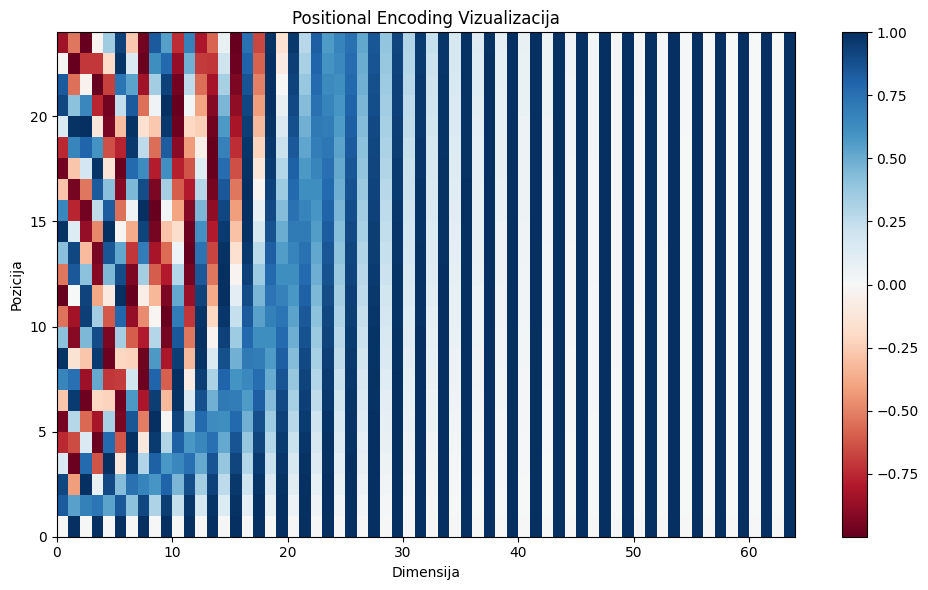

In [12]:
# --- 6. Positional Encoding implementacija ---
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Patikriname Positional Encoding
seq_len = sequence_length
d_model = 64
pos_encoding = get_positional_encoding(seq_len, d_model)
print(f"Positional encoding shape: {pos_encoding.shape}")

# Vizualizuojame Positional Encoding
plt.figure(figsize=(10, 6))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.title('Positional Encoding Vizualizacija')
plt.xlabel('Dimensija')
plt.ylabel('Pozicija')
plt.colorbar()
plt.tight_layout()
plt.show()

In [13]:
# --- 7. TimeSeriesTransformer modelio aprašymas ---
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, seq_len, num_features, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout
        
        # Embedding sluoksnis
        self.embedding = layers.Dense(d_model)
        
        # Positional encoding
        self.pos_encoding = get_positional_encoding(seq_len, d_model)
        
        # Multi-head attention
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed-forward network
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model),
        ])
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Output layers
        self.flatten = layers.Flatten()
        self.out = layers.Dense(1)

    def call(self, x, training=False):
        print_shapes = False  # Nustatykite į True, jei norite debuginti
        
        if print_shapes:
            print(f"Input x shape: {x.shape}")
        
        # Embedding
        x = self.embedding(x)
        if print_shapes:
            print(f"After embedding shape: {x.shape}")
        
        # Add positional encoding
        x = x + self.pos_encoding
        if print_shapes:
            print(f"After adding positional encoding shape: {x.shape}")
        
        # Multi-head attention
        attn_output = self.attention(x, x)
        if print_shapes:
            print(f"After attention shape: {attn_output.shape}")
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(x + attn_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.norm2(out1 + ffn_output)
        
        # Output
        out2 = self.flatten(out2)
        if print_shapes:
            print(f"After flatten shape: {out2.shape}")
        
        output = self.out(out2)
        if print_shapes:
            print(f"Final output shape: {output.shape}")
        
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "seq_len": self.seq_len,
            "num_features": self.num_features,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout_rate,
        })
        return config

In [14]:
# --- 8. Transformer modelio sukūrimas ---
d_model = 64
num_heads = 4
ff_dim = 128
dropout = 0.1

# Patikriname input shape
print(f"X_train shape: {X_train.shape}")
print(f"sequence_length: {sequence_length}, num_features: {X_train.shape[2]}")

# Tikriname, ar model.summary() veikia
transformer_model = TimeSeriesTransformer(
    seq_len=sequence_length,
    num_features=X_train.shape[2],
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout
)

# Tiesiogiai perduodame duomenis ir tikriname output
test_batch = X_train[:2]  # Pirmi 2 pavyzdžiai
print(f"Test batch shape: {test_batch.shape}")
with tf.GradientTape() as tape:
    output = transformer_model(test_batch, training=True)
    print(f"Output shape: {output.shape}")
    print(f"Output values: {output.numpy()}")

# Dabar jau turėtume galėti sukompiliuoti modelį
transformer_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

transformer_model.build(input_shape=(None, sequence_length, X_train.shape[2]))
transformer_model.summary()

X_train shape: (140054, 24, 5)
sequence_length: 24, num_features: 5
Test batch shape: (2, 24, 5)
Output shape: (2, 1)
Output values: [[0.70947844]
 [0.21934938]]


Model: "time_series_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (2, 24, 64)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention            │ (2, 24, 64)            │        66,368 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (2, 24, 64)            │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (2, 24, 64)            │        16,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (2, 24, 64)            │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (2, 1536)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (2, 1)                 │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,121 (332.50 KB)

 Trainable params: 85,121 (332.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# --- 9. Modelio apmokymas ---
os.makedirs('../../models', exist_ok=True)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
checkpoint = callbacks.ModelCheckpoint(
    filepath='../../models/transformer_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Patikrinimas, ar duomenys teisingai paruošti
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

# Apmokymo paleidimas
print("Pradedamas modelio apmokymas...")
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("Modelio apmokymas baigtas.")

# Išsaugome modelį
transformer_model.save('../../models/transformer_model.h5')
print("Modelis išsaugotas į: ../../models/transformer_model.h5")

X_train.shape: (140054, 24, 5), y_train.shape: (140054,)
X_test.shape: (35014, 24, 5), y_test.shape: (35014,)
Pradedamas modelio apmokymas...
Epoch 1/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0575 - mae: 0.1135
Epoch 1: val_loss improved from inf to 0.00277, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 88s 19ms/step - loss: 0.0575 - mae: 0.1135 - val_loss: 0.0028 - val_mae: 0.0465 - learning_rate: 0.0010
Epoch 2/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - mae: 0.0305
Epoch 2: val_loss did not improve from 0.00277
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - loss: 0.0017 - mae: 0.0305 - val_loss: 0.0039 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 3/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.8724e-04 - mae: 0.0172
Epoch 3: val_loss did not improve from 0.00277
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - loss: 5.8724e-04 - mae: 0.0172 - val_loss: 0.0059 - val_mae: 0.0668 - learning_rate: 0.0010
Epoch 4/50
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7618e-04 - mae: 0.0120
Epoch 4: val_loss did not improve from 0.00277
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - loss: 2.7616e-04 - mae: 0.0120 - val_loss: 0.0028 - val_mae: 0.0361 - learning_rate: 0.0010
Epoch 5/50
4373/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

4377/4377 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 4.2116e-05 - mae: 0.0050 - val_loss: 0.0014 - val_mae: 0.0273 - learning_rate: 0.0010
Epoch 7/50
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6338e-05 - mae: 0.0047
Epoch 7: val_loss improved from 0.00142 to 0.00092, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 3.6336e-05 - mae: 0.0047 - val_loss: 9.1568e-04 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 8/50
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9183e-05 - mae: 0.0040
Epoch 8: val_loss improved from 0.00092 to 0.00019, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - loss: 2.9185e-05 - mae: 0.0040 - val_loss: 1.9492e-04 - val_mae: 0.0105 - learning_rate: 0.0010
Epoch 9/50
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7152e-05 - mae: 0.0032
Epoch 9: val_loss improved from 0.00019 to 0.00013, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 1.7152e-05 - mae: 0.0032 - val_loss: 1.2692e-04 - val_mae: 0.0084 - learning_rate: 0.0010
Epoch 10/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2931e-05 - mae: 0.0030
Epoch 10: val_loss improved from 0.00013 to 0.00003, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 60s 14ms/step - loss: 2.2925e-05 - mae: 0.0030 - val_loss: 2.7847e-05 - val_mae: 0.0043 - learning_rate: 0.0010
Epoch 11/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1486e-05 - mae: 0.0026
Epoch 11: val_loss improved from 0.00003 to 0.00001, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - loss: 1.1486e-05 - mae: 0.0026 - val_loss: 1.4998e-05 - val_mae: 0.0032 - learning_rate: 0.0010
Epoch 12/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9871e-05 - mae: 0.0027
Epoch 12: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - loss: 3.9856e-05 - mae: 0.0027 - val_loss: 6.0998e-05 - val_mae: 0.0058 - learning_rate: 0.0010
Epoch 13/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.2871e-06 - mae: 0.0022
Epoch 13: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 8.2872e-06 - mae: 0.0022 - val_loss: 1.8278e-05 - val_mae: 0.0031 - learning_rate: 0.0010
Epoch 14/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9425e-06 - mae: 0.0021
Epoch 14: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - loss: 7.9424e-06 - mae: 0.0021 - val_loss: 4.5529e-05 - val_mae: 0.0060 - learning_rate: 0.0010
Epoch 15/50
4375/


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - loss: 1.6128e-05 - mae: 0.0021 - val_loss: 8.6972e-06 - val_mae: 0.0021 - learning_rate: 0.0010
Epoch 16/50
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8640e-06 - mae: 0.0011
Epoch 16: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 2.8641e-06 - mae: 0.0011 - val_loss: 1.2978e-05 - val_mae: 0.0025 - learning_rate: 2.0000e-04
Epoch 17/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1889e-06 - mae: 0.0012
Epoch 17: val_loss improved from 0.00001 to 0.00001, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - loss: 3.1888e-06 - mae: 0.0012 - val_loss: 8.3154e-06 - val_mae: 0.0019 - learning_rate: 2.0000e-04
Epoch 18/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1636e-06 - mae: 0.0012
Epoch 18: val_loss improved from 0.00001 to 0.00001, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 3.1635e-06 - mae: 0.0012 - val_loss: 7.3092e-06 - val_mae: 0.0018 - learning_rate: 2.0000e-04
Epoch 19/50
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0360e-06 - mae: 0.0012
Epoch 19: val_loss improved from 0.00001 to 0.00001, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - loss: 3.0360e-06 - mae: 0.0012 - val_loss: 7.0171e-06 - val_mae: 0.0018 - learning_rate: 2.0000e-04
Epoch 20/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9963e-06 - mae: 0.0012
Epoch 20: val_loss did not improve from 0.00001

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001.
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 2.9963e-06 - mae: 0.0012 - val_loss: 8.2505e-06 - val_mae: 0.0020 - learning_rate: 2.0000e-04
Epoch 21/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5417e-06 - mae: 0.0011
Epoch 21: val_loss improved from 0.00001 to 0.00001, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 2.5417e-06 - mae: 0.0011 - val_loss: 6.7720e-06 - val_mae: 0.0017 - learning_rate: 1.0000e-04
Epoch 22/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5826e-06 - mae: 0.0011
Epoch 22: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 66s 15ms/step - loss: 2.5826e-06 - mae: 0.0011 - val_loss: 8.9727e-06 - val_mae: 0.0021 - learning_rate: 1.0000e-04
Epoch 23/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5497e-06 - mae: 0.0011
Epoch 23: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 2.5497e-06 - mae: 0.0011 - val_loss: 9.1610e-06 - val_mae: 0.0022 - learning_rate: 1.0000e-04
Epoch 24/50
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5290e-06 - mae: 0.0011
Epoch 24: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 2.5290e-06 - mae: 0.0011 - val_loss: 8.8283e-06 - val_mae: 0.0021 - learning_rate: 1.0000e-04
E

4377/4377 ━━━━━━━━━━━━━━━━━━━━ 66s 15ms/step - loss: 2.5173e-06 - mae: 0.0011 - val_loss: 6.2197e-06 - val_mae: 0.0017 - learning_rate: 1.0000e-04
Epoch 26/50
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5245e-06 - mae: 0.0011
Epoch 26: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - loss: 2.5245e-06 - mae: 0.0011 - val_loss: 9.0139e-06 - val_mae: 0.0022 - learning_rate: 1.0000e-04
Epoch 27/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5013e-06 - mae: 0.0010
Epoch 27: val_loss improved from 0.00001 to 0.00001, saving model to ../../models/transformer_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - loss: 2.5013e-06 - mae: 0.0010 - val_loss: 6.0609e-06 - val_mae: 0.0016 - learning_rate: 1.0000e-04
Epoch 28/50
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4977e-06 - mae: 0.0010
Epoch 28: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - loss: 2.4977e-06 - mae: 0.0010 - val_loss: 7.9378e-06 - val_mae: 0.0020 - learning_rate: 1.0000e-04
Epoch 29/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5069e-06 - mae: 0.0011
Epoch 29: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 2.5069e-06 - mae: 0.0011 - val_loss: 6.4213e-06 - val_mae: 0.0017 - learning_rate: 1.0000e-04
Epoch 30/50
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4539e-06 - mae: 0.0010
Epoch 30: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - loss: 2.4538e-06 - mae: 0.0010 - val_loss: 6.2706e-06 - val_mae: 0.0017 - learning_rate: 1.0000e-04
E

4377/4377 ━━━━━━━━━━━━━━━━━━━━ 66s 15ms/step - loss: 2.4514e-06 - mae: 0.0010 - val_loss: 5.0872e-06 - val_mae: 0.0015 - learning_rate: 1.0000e-04
Epoch 33/50
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4343e-06 - mae: 0.0010
Epoch 33: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 2.4343e-06 - mae: 0.0010 - val_loss: 5.5678e-06 - val_mae: 0.0016 - learning_rate: 1.0000e-04
Epoch 34/50
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4283e-06 - mae: 0.0010
Epoch 34: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 69s 16ms/step - loss: 2.4283e-06 - mae: 0.0010 - val_loss: 5.4126e-06 - val_mae: 0.0015 - learning_rate: 1.0000e-04
Epoch 35/50
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4373e-06 - mae: 0.0010
Epoch 35: val_loss did not improve from 0.00001
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 2.4372e-06 - mae: 0.0010 - val_loss: 8.0490e-06 - val_mae: 0.0021 - learning_rate: 1.0000e-04
E

Modelio apmokymas baigtas.
Modelis išsaugotas į: ../../models/transformer_model.h5


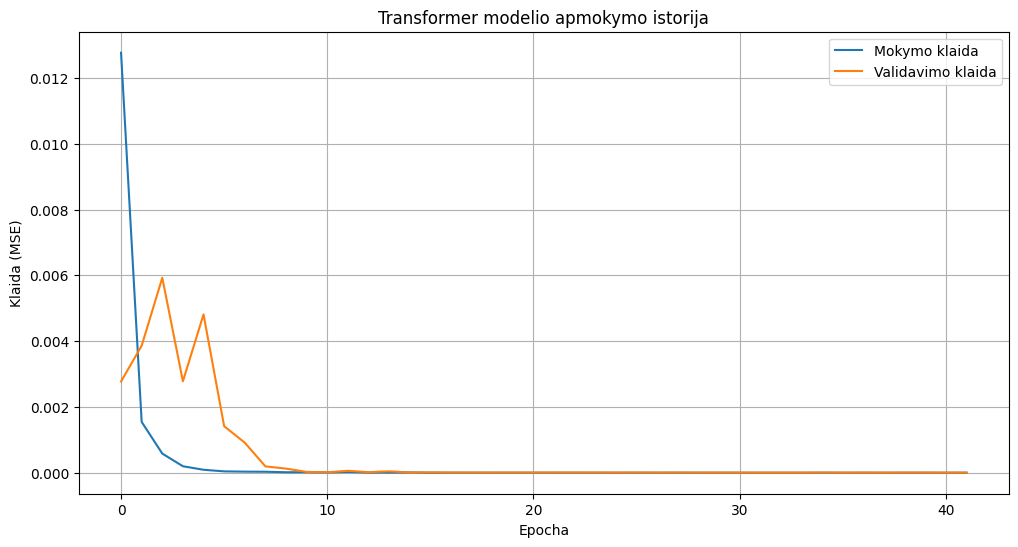

In [16]:
# --- 10. Apmokymo istorijos vizualizacija ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Mokymo klaida')
plt.plot(history.history['val_loss'], label='Validavimo klaida')
plt.title('Transformer modelio apmokymo istorija')
plt.xlabel('Epocha')
plt.ylabel('Klaida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

if 'lr' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Kitimas')
    plt.xlabel('Epocha')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

In [17]:
# --- 11. Prognozės ir atstatymas į originalią skalę ---
print("Generuojamos prognozės...")
y_pred = transformer_model.predict(X_test)
print(f"Prognozių forma: {y_pred.shape}")

def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_names=None):
    dummy = np.zeros((len(predictions), len(feature_names) if feature_names else 5))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

target_idx = feature_columns.index(target_column)
y_pred_original = inverse_transform_predictions(y_pred, scaler, target_idx, feature_columns)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx, feature_columns)

print(f"y_pred_original shape: {y_pred_original.shape}")
print(f"y_test_original shape: {y_test_original.shape}")

Generuojamos prognozės...
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Prognozių forma: (35014, 1)
y_pred_original shape: (35014,)
y_test_original shape: (35014,)


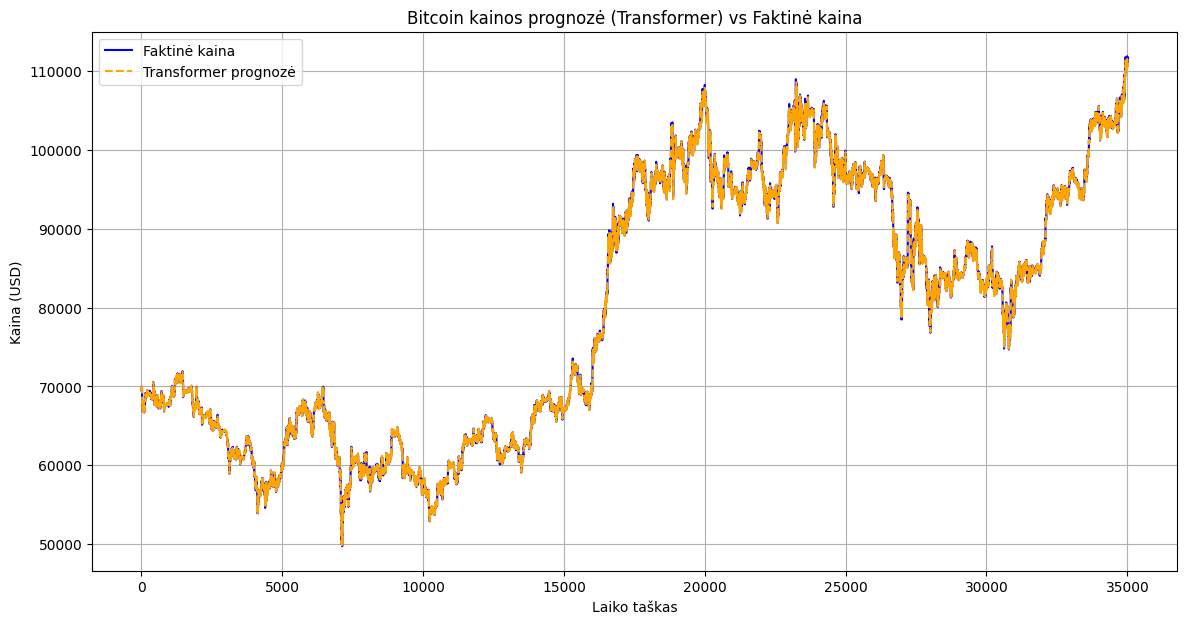

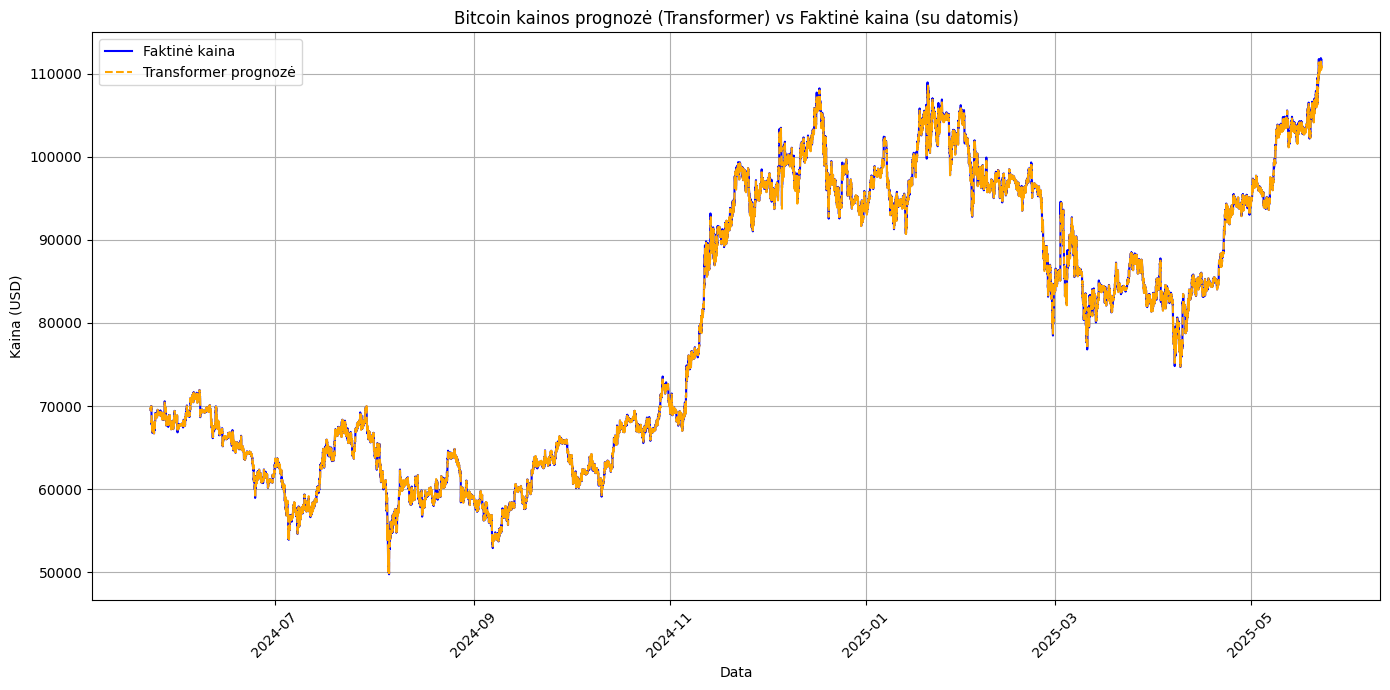

In [18]:
# --- 12. Prognozių vizualizacija ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Faktinė kaina', color='blue')
plt.plot(y_pred_original, label='Transformer prognozė', color='orange', linestyle='--')
plt.title('Bitcoin kainos prognozė (Transformer) vs Faktinė kaina')
plt.xlabel('Laiko taškas')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Su datomis
test_dates = df_original['time'].iloc[-len(y_test):].reset_index(drop=True)
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='blue')
plt.plot(test_dates, y_pred_original, label='Transformer prognozė', color='orange', linestyle='--')
plt.title('Bitcoin kainos prognozė (Transformer) vs Faktinė kaina (su datomis)')
plt.xlabel('Data')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# --- 13. Modelio įvertinimas ---
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Sukuriame DataFrame geresniam pavaizavimui
metrics_df = pd.DataFrame({
    'Metrika': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Reikšmė': [mse, rmse, mae, r2, mape]
})
display(metrics_df)

Mean Squared Error (MSE): 54189.67
Root Mean Squared Error (RMSE): 232.79
Mean Absolute Error (MAE): 149.80
R² Score: 0.9998
Mean Absolute Percentage Error (MAPE): 0.19%


,Metrika,Reikšmė
0,MSE,54189.665182
1,RMSE,232.786738
2,MAE,149.798554
3,R²,0.999798
4,MAPE (%),0.186601


In [20]:
# --- 14. Modelio informacijos išsaugojimas ---
import json

model_info = {
    'model_type': 'Transformer',
    'input_shape': [sequence_length, len(feature_columns)],
    'sequence_length': sequence_length,
    'target_column': target_column,
    'params': {
        'd_model': d_model,
        'num_heads': num_heads,
        'ff_dim': ff_dim,
        'dropout': dropout
    },
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'mape': float(mape)
    }
}

model_info_path = '../../models/transformer_model_info.json'
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Modelio informacija išsaugota: {model_info_path}")
print("Transformer modelio apmokymas ir įvertinimas baigtas!")

Modelio informacija išsaugota: ../../models/transformer_model_info.json
Transformer modelio apmokymas ir įvertinimas baigtas!


In [21]:
# Transformer modelio eksportavimas į aplikacijos modelių aplanką
import os
import joblib

target_dir = 'd:/CA_BTC/app/models/transformer'
os.makedirs(target_dir, exist_ok=True)

# Išsaugome modelį
transformer_model.save(os.path.join(target_dir, 'transformer_model.h5'))
print(f"Modelis išsaugotas į: {os.path.join(target_dir, 'transformer_model.h5')}")

# Išsaugome scaler'į
with open(os.path.join(target_dir, 'transformer_scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler išsaugotas į: {os.path.join(target_dir, 'transformer_scaler.pkl')}")

# Išsaugome konfigūraciją
config_data = {
    'model_type': 'transformer',
    'sequence_length': sequence_length,
    'features': feature_columns,
    'target': target_column,
    'hyperparameters': {
        'd_model': d_model,
        'num_heads': num_heads,
        'ff_dim': ff_dim,
        'dropout': dropout
    },
    'training_info': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1])
    }
}

import json
with open(os.path.join(target_dir, 'config.json'), 'w') as f:
    json.dump(config_data, f, indent=4)
print(f"Konfigūracija išsaugota į: {os.path.join(target_dir, 'config.json')}")

Modelis išsaugotas į: d:/CA_BTC/app/models/transformer\transformer_model.h5
Scaler išsaugotas į: d:/CA_BTC/app/models/transformer\transformer_scaler.pkl
Konfigūracija išsaugota į: d:/CA_BTC/app/models/transformer\config.json


In [22]:
# Patikrinti ir paruošti duomenis aplikacijai
print("=== MODELIO EKSPORTAVIMO ATSKAITA ===")
print(f"Duomenų šaltinis: {data_file_path}")
print(f"Duomenų kiekis: {len(df)} įrašų")
print(f"Laiko intervalas: {df['time'].min()} - {df['time'].max()}")
print(f"Normalizuoti stulpeliai: {columns_to_normalize}")
print(f"Sekos ilgis: {sequence_length}")
print(f"Mokymo duomenų kiekis: {len(X_train)}")
print(f"Testavimo duomenų kiekis: {len(X_test)}")

# Patikrinti, ar modelis veikia
test_prediction = transformer_model.predict(X_test[:5])
print(f"Testo prognozės formos: {test_prediction.shape}")
print(f"Pavyzdinės prognozės: {test_prediction.flatten()[:5]}")

print("\n=== MODELIO FAILAI ===")
target_dir = 'd:/CA_BTC/app/models/transformer'
files_created = []
for file_name in ['transformer_model.h5', 'transformer_scaler.pkl', 'config.json']:
    file_path = os.path.join(target_dir, file_name)
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024 / 1024  # MB
        files_created.append(f"✓ {file_name}: {file_size:.2f} MB")
    else:
        files_created.append(f"✗ {file_name}: NEPAVYKO SUKURTI")

for file_info in files_created:
    print(file_info)

print("\nTransformer modelis paruoštas naudojimui aplikacijoje!")

=== MODELIO EKSPORTAVIMO ATSKAITA ===
Duomenų šaltinis: ..\..\data\btc_data_1y_15m.csv
Duomenų kiekis: 175092 įrašų
Laiko intervalas: 2020-05-24 00:00:00 - 2025-05-22 23:45:00
Normalizuoti stulpeliai: ['open', 'high', 'low', 'close', 'volume']
Sekos ilgis: 24
Mokymo duomenų kiekis: 140054
Testavimo duomenų kiekis: 35014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Testo prognozės formos: (5, 1)
Pavyzdinės prognozės: [0.58847296 0.5893657  0.5900114  0.5893627  0.58958286]

=== MODELIO FAILAI ===
✓ transformer_model.h5: 1.04 MB
✓ transformer_scaler.pkl: 0.00 MB
✓ config.json: 0.00 MB

Transformer modelis paruoštas naudojimui aplikacijoje!
